In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.restoration import wiener, richardson_lucy, denoise_tv_chambolle
from scipy.fft import fft2, ifft2
import matplotlib.pyplot as plt
import numpy as np

# helper function for forward operator
def K(inp,psf=[],mode='forward'):
    n = inp.shape[0]
    k_hat = fft2(psf,s=(n,n))
    inp_hat = fft2(inp)
    if mode == 'forward':
        outp = ifft2(k_hat * inp_hat)
    if mode == 'adjoint':
        outp = ifft2(np.conj(k_hat) * inp_hat)
    if mode == 'inv':
        outp = ifft2( np.conj(k_hat) * inp_hat / ( np.conj(k_hat) * k_hat ) )
        
    return np.real(outp)

# helper function for plotting
def plot_images(images, titles, fname=[], scale = [0,1]):
    m = len(images)
    fig, ax = plt.subplots(1,m)
    
    if m > 1:
        for k in range(m):
            ax[k].set_xticks([])
            ax[k].set_yticks([])
            ax[k].imshow(images[k], cmap=plt.cm.gray, vmin=scale[0], vmax=scale[1])
            ax[k].set_title(titles[k])
    else:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(images[0], cmap=plt.cm.gray, vmin=scale[0], vmax=scale[1])
        ax.set_title(titles[0])
    fig.set_figwidth(10)
    fig.tight_layout()
    
    if fname:
        plt.savefig(fname,dpi=300)
        
def squares_image(n):
    u = np.zeros((n,n))
    u[n//6:n//6+7*n//12, n//6:n//6+7*n//12] = .5
    u[2*n//3:2*n//3+n//6, 2*n//3:2*n//3+n//6] = 1
    
    return u

def show_data(U,m,n):
    fig, ax = plt.subplots(m,n)
    k = 0
    for i in range(m):
        for j in range(n):
            ax[i,j].imshow(U[k,:].reshape(8,8),cmap='gray')
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            k += 1
    fig.tight_layout()

# Inverse Problems

![](enhance.jpeg)

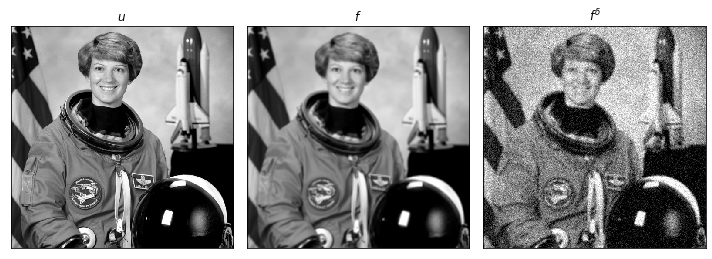

In [2]:
# read image
u = rgb2gray(data.astronaut())

# blur image
kernel = np.ones((5, 5)) / 25
f = K(u,psf = kernel)

# add_noise
delta = 0.1
f_delta = f + delta * np.random.randn(f.shape[0],f.shape[1])

# plot
plot_images([u, f, f_delta], [r'$u$', r'$f$', r'$f^\delta$'])

# Overview

* Inverse Problems
* Regularisation (linear and non-linear filters)
* Data-driven methods (dictionar learning and neural networks)

# Inverse problems in imaging

* $K$ - forward operator (convolution with PSF)
* $u$ - image (function or 2D array representing RGB values or intensity)
* $f$ - noiseless measurements ($f = Ku$)
* $f^\delta$ - noisey measurements ($f^\delta = f + \epsilon$ for additive noise)

> The goal is to retrieve $u$ given $K$ and $f^\delta$

# Well-posedness

An inverse problem is *well-posed* if 

* a solution exists
* the solution is unique
* the solution is stable

# Pseudo-inverse

$$\widetilde{u} = K^\dagger f^\delta = \mathcal{F}^{-1} \left(\frac{\widehat{k}^* \widehat{f}^\delta}{|\widehat{k}|^2}\right).$$

* Gives the solution for which $K^*\!K\widetilde{u} = K^*f^\delta$ that does not contain any elements in the nullspace of $K$
* How sensitive is this solution to noise?

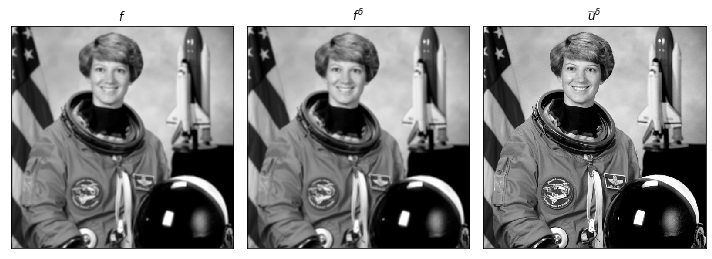

In [6]:
# read image
u = rgb2gray(data.astronaut())

# blur image
psf = np.ones((5, 5)) / 25
f = K(u, psf = kernel)

# add_noise
delta = 1e-6
f_delta = f + delta * np.random.randn(f.shape[0],f.shape[1])

# inverse
u_est = K(f_delta, psf = kernel, mode = 'inv')

# plot
plot_images([f, f_delta, u_est], [r'$f$', r'$f^\delta$', r'$\widetilde{u}^\delta$'])

## Assignment

* How does this method perform when you add noise to the data?
* Can you think of a way to improve the method

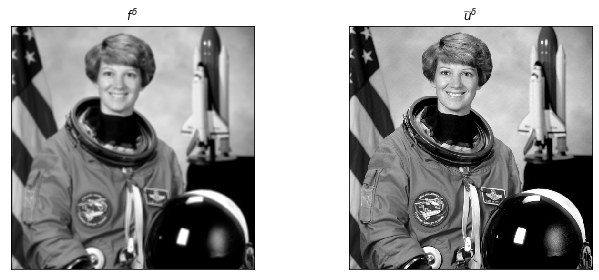

In [7]:
# read image
u = rgb2gray(data.astronaut())

# blur image
psf = np.ones((5, 5)) / 25
f = K(u, psf = kernel)

# add_noise
delta = 1e-6
f_delta =  f + delta * np.random.randn(f.shape[0],f.shape[1])

# deconvolution in Fourier domain
k_hat = fft2(psf,s=f.shape)
f_hat = fft2(f_delta)
u_est = np.real( ifft2( ( np.conj(k_hat) * f_hat ) / ( np.conj(k_hat) * k_hat ) ) )


# plot
plot_images([f_delta, u_est], [r'$f^\delta$', r'$\widetilde{u}^\delta$'])